<a href="https://colab.research.google.com/github/synsense/snn-workshop-amld-2022/blob/master/2.%20vision%20processing/AMLD_train_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dance recognition training - full

## Setup
First we download the dataset and install missing packages.

In [4]:
### --- Download and install dataset
import zipfile
from pathlib import Path

dataset_path = Path("/content") / "body-postures-dataset"

if not dataset_path.exists():
  !wget -q --show-progress https://www.dropbox.com/s/b9gfafnh6aesrsu/body-postures-dataset.bin
  # alternative mirror: https://lenzgregor.com/nextcloud/s/tbamCq9Eo95qfLc/download/body-postures-dataset.bin
  !mv body-postures-dataset.bin body-postures-dataset.tar.gz
  !tar -xzf body-postures-dataset.tar.gz

!pip install ./body-postures-dataset --quiet
!pip install torchmetrics --quiet

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [5]:
import torch
import torchmetrics
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torch.utils.data.sampler import WeightedRandomSampler

from body_postures import BodyPostureFrames

## Data inspection

The dataset is imbalanced. Let's look at training and testing set distribution and rectify the training set by using weighted random sampling.

In [6]:
?BodyPostureFrames

In [7]:
event_count = 3000
hot_pixel_filter_freq = 60

frame_dataset_training = BodyPostureFrames(
    data_path=dataset_path / "data" / "train",
    event_count=event_count,
    hot_pixel_filter_freq=hot_pixel_filter_freq,
    metadata_path=f'metadata/frames/train/{event_count}events_{hot_pixel_filter_freq}filter',
)

frame_dataset_validation = BodyPostureFrames(
    data_path=dataset_path / "data" / "test",
    event_count=event_count,
    hot_pixel_filter_freq=hot_pixel_filter_freq,
    metadata_path=f'metadata/frames/test/{event_count}events_{hot_pixel_filter_freq}filter',
)
classes = frame_dataset_training.classes
shape = frame_dataset_training.shape
n_classes = len(classes)


Metadata written to disk.
Metadata written to disk.


In [8]:
def get_weight_sampler(dataset):
  targets = []
  for data, target in iter(dataset):
    targets.append(target)
  targets = np.array(targets)

  count = np.bincount(targets)
  frac = count / np.sum(count)
  sample_weights_per_class = dict(zip(range(n_classes), 1 / frac / count.sum()))

  sample_weights = [sample_weights_per_class[target] for target in targets]
  sampler = WeightedRandomSampler(sample_weights, len(dataset), replacement=True)
  return sampler

In [9]:
batch_size = 256
train_loader = DataLoader(
    dataset=frame_dataset_training, 
    batch_size=batch_size,
    sampler=get_weight_sampler(frame_dataset_training)
    )

test_loader = DataLoader(
    dataset=frame_dataset_validation,
    batch_size=batch_size,
    )

In [10]:
def plot_sample_dist(dataloader):
  resampled_targets = []
  for data, target in iter(dataloader):
    resampled_targets.append(target)
  resampled_targets = torch.cat(resampled_targets).numpy()

  plt.bar(classes.keys(), np.bincount(resampled_targets))
  plt.ylabel("Number of samples")

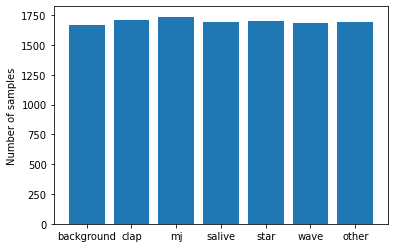

In [11]:
plot_sample_dist(train_loader)

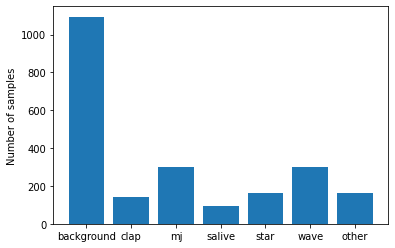

In [12]:
plot_sample_dist(test_loader)

### Settings and hyperparameters

In [13]:
learning_rate = 1e-3
weight_decay = 0
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device {device}.")

Using device cuda.


### Model definition

In [14]:
class ANN(nn.Sequential):
    def __init__(self, n_classes=10):
        super().__init__(
            nn.Conv2d(2, 16, kernel_size=(3, 3), stride=2, padding=1, bias=False),  # 16, 64, 64
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2)),  # 16, 32, 32
            nn.Dropout2d(0.1),
            
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=2, padding=1, bias=False),  # 32, 16, 16
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2)),  # 32, 8, 8
            nn.Dropout2d(0.25),
            
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=1, padding=1, bias=False),  # 64, 4, 4
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2, 2)),  # 64, 2, 2
            nn.Flatten(),
            nn.Dropout2d(0.5),
            
            nn.Linear(32*4*4, n_classes, bias=False),
        )

In [ ]:
ann = ANN(n_classes).to(device)

# - Loss
criterion = torch.nn.CrossEntropyLoss()

# - Optimizer
optimizer = torch.optim.Adam(ann.parameters(), lr=learning_rate, weight_decay=weight_decay)

# - Confusion matrix
confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=n_classes)

num_epochs = 100
validate_every = 5

# We use augmentation because we're oversampling underrepresented classes. 
augmentation = torchvision.transforms.RandomAffine(degrees=10, translate=[0.1, 0.1])

# Track losses
training_losses = []
val_losses = []
val_accuracy = 0
val_loss = 0

pbar_epoch = tqdm(range(num_epochs), desc="Epochs")
for epoch in pbar_epoch:
    batch_loss = []
    for data, labels in iter(train_loader):
        # Forward pass
        data = data.to(device)
        data = augmentation(data)
        logits = ann(data)
        # Loss for current batch
        loss = criterion(logits, labels.to(device))
        # Backward pass
        loss.backward()
        # Update parameters
        optimizer.step()
        optimizer.zero_grad()
        batch_loss.append(loss.item())

    train_loss = sum(batch_loss) / len(batch_loss)
    training_losses.append(train_loss)
    pbar_epoch.set_postfix(train_loss=train_loss, val_loss=val_loss, val_acc=val_accuracy)
    
    # Validation
    if validate_every is not None and (epoch + 1) % validate_every == 0:
        with torch.no_grad():
            val_data = []
            batch_loss = []
            for data, labels in iter(test_loader):
                logits = ann(data.to(device))
                # Loss
                loss = criterion(logits, labels.to(device))
                batch_loss.append(loss.item())
                # Collect outputs and labels
                predictions = torch.max(logits, dim=1)[1]
                val_data.append((predictions.detach().cpu(), labels.detach().cpu()))
            
            val_loss = sum(batch_loss) / len(batch_loss)
            val_losses.append(val_loss)

            # Calculate accuracy
            confusion_list = [confusion_matrix(pred, label) for pred, label in val_data]
            confusion = torch.stack(confusion_list).sum(0)
            val_accuracy = (confusion.trace() / confusion.sum()).item()
            
        pbar_epoch.set_postfix(train_loss=train_loss, val_loss=val_loss, val_acc=val_accuracy)
            

        

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
plt.plot(training_losses)
plt.plot(range(0, len(training_losses), validate_every), val_losses)

# Convert ANN to SNN

In [ ]:
ann

In [ ]:
sinabs_path = Path("/content") / "sinabs"

if not sinabs_path.exists():
  !git clone https://github.com/synsense/sinabs.git
  !cd sinabs; pip install . --quiet

In [ ]:
import sinabs
import copy

ann_copy = copy.deepcopy(ann)

spike_layers = [name for name, child in ann_copy.cpu().named_children() if isinstance(child, nn.ReLU)]
param_layers = [name for name, child in ann_copy.cpu().named_children() if isinstance(child, (nn.Conv2d, nn.Linear))]
data = next(iter(train_loader))[0]

sinabs.utils.normalize_weights(ann_copy, data, output_layers=spike_layers, param_layers=param_layers)

We can scale the weights of the first layer to help the network with decision making. 

In [ ]:
with torch.no_grad():
  ann_copy[0].weight *= 5

In [ ]:
snn = sinabs.from_torch.from_model(ann_copy, input_shape=shape[::-1], add_spiking_output=True)
snn

In [ ]:
torch.save(snn, 'model.pth')

## Evaluate converted SNN on raster data

In [ ]:
from body_postures import BodyPostureRaster

In [ ]:
try:
  snn = torch.load('model.pth')
  print("Loaded saved model.")
except Exception as e:
  print(e)

In [ ]:
?BodyPostureRaster

In [ ]:
slice_dt = 2e6 # microseconds
bin_dt = 2e3
batch_size = 1

raster_test_dataset = BodyPostureRaster(
    data_path=dataset_path / "data" / "test",
    cache_path=f"cache/train/{slice_dt}/{bin_dt}",
    slice_dt=slice_dt,
    bin_dt=bin_dt,
    metadata_path=f"metadata/raster/test/{slice_dt}/{bin_dt}",
    hot_pixel_filter_freq=hot_pixel_filter_freq,
)

test_loader = DataLoader(raster_test_dataset, shuffle=True, batch_size=batch_size)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

snn.eval()
snn = snn.to(device)

val_data = []
batch_loss = []
for data, labels in tqdm(test_loader):
  with torch.no_grad():
    snn.reset_states()
    data = data.to(device)
    data = data.flatten(0, 1).float()
    spikes = snn(data).unflatten(0, (batch_size, -1))

    # Collect outputs and labels
    labels = labels.to(device)
    predictions = spikes.sum(1).argmax(dim=1) 
    val_data.append(predictions.eq(labels.view_as(predictions)))
    print(f"Spike output: {spikes.sum(1).int().tolist()[0]}, label was {labels.item()}. Overall accuracy: {round((sum(val_data)/len(val_data)).item(), 3)}")  